In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


i.
Images in each class are given in separate folders. The file
Classes.xlsx
pro-
vides the classes assigned to the bird species images in each folder. Therefore,
you encode your classes using one-hot encoding and
Classes.xlsx
.

ii.
Randomly select
d
0
.
7
n
i
e
images from each folder as your training set,
d
0
.
15
n
i
e
as validation set, and the rest as your test set, where
n
i
is the number of
images in folder
i
and
d
x
e
is the ceiling of
x

iii.
In order for all the images to have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.

In [11]:
input_folder = '/content/drive/MyDrive/project/images'
splitfolders.ratio(input_folder,output = 'output', seed = 1,ratio = (0.7,0.15,0.15))

Copying files: 1176 files [07:20,  2.67 files/s]


In [12]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/output/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224))
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/output/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224))

Found 820 files belonging to 20 classes.
Found 171 files belonging to 20 classes.
Found 185 files belonging to 20 classes.


In [13]:
size = (224,224)
ds_train = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = validation_ds.map(lambda image, label: (tf.image.resize(image, size), label))

(c)

In [14]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [15]:
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy() 

In [47]:
epochs = 100
steps_per_epoch = len(ds_train)
validation_steps = len(ds_val)

(c) Train the networks (EfficientNetB0 and VGG16) for 100 epochs and perform early stopping using the validation set.
Plot the training and validation errors vs. epochs.
Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM.

In [48]:
def create_eff_model():
  with strategy.scope():
      inputs = layers.Input(shape=(224, 224, 3))
      x = img_augmentation(inputs)
      outputs = EfficientNetB0(include_top=False, 
                               weights='imagenet', 
                               classes=20)(x)
      model_ENB0 = tf.keras.Model(inputs, outputs)

  model = Sequential()
  model.add(model_ENB0)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=64,activation="relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(units=20, activation="softmax"))
  
  for layer in model.layers[:-1]:
    layer.trainable = False

  model.summary()

  model.compile(
      optimizer=Adam(learning_rate=1e-2),
      loss="categorical_crossentropy", 
      metrics=["accuracy"])

  return model

create_eff_model()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_19 (Functional)       (None, 7, 7, 1280)        4049571   
                                                                 
 global_average_pooling2d_19  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 20)              

In [49]:
model_eff = create_eff_model()
checkpoint_eff = ModelCheckpoint("eff_1.h5", 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              period=1)

early_eff = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

history_eff = model_eff.fit_generator(ds_train,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=epochs,
                                  validation_data=ds_val,
                                  validation_steps=validation_steps,
                                  callbacks=[checkpoint_eff, early_eff])
  

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_20 (Functional)       (None, 7, 7, 1280)        4049571   
                                                                 
 global_average_pooling2d_20  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_20 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 20)              

Epoch 1/100


<ipython-input-49-94c80dcf547c>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_eff = model_eff.fit_generator(ds_train,


13/13 [==============================] - ETA: 0s - loss: 2.9575 - accuracy: 0.0854
Epoch 1: val_accuracy improved from -inf to 0.21053, saving model to eff_1.h5
13/13 [==============================] - 23s 919ms/step - loss: 2.9575 - accuracy: 0.0854 - val_loss: 2.7764 - val_accuracy: 0.2105
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 2.6547 - accuracy: 0.2183
Epoch 2: val_accuracy improved from 0.21053 to 0.39181, saving model to eff_1.h5
13/13 [==============================] - 12s 818ms/step - loss: 2.6547 - accuracy: 0.2183 - val_loss: 2.5096 - val_accuracy: 0.3918
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 2.4076 - accuracy: 0.3585
Epoch 3: val_accuracy improved from 0.39181 to 0.51462, saving model to eff_1.h5
13/13 [==============================] - 12s 859ms/step - loss: 2.4076 - accuracy: 0.3585 - val_loss: 2.2933 - val_accuracy: 0.5146
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 2.2393 - accuracy: 0.4

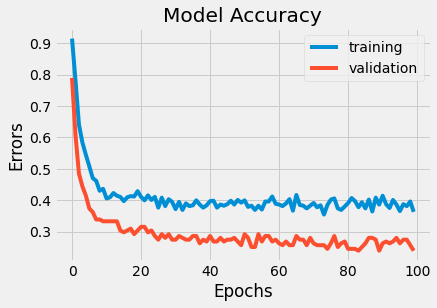

In [50]:
def plot_eff():
  errors = [1 - x for x in history_eff.history['accuracy']]
  val_errors = [1 - x for x in history_eff.history['val_accuracy']]
  plt.style.use('fivethirtyeight')
  plt.title('Model Accuracy')
  plt.plot(errors, label="training")
  plt.plot(val_errors, label="validation")
  plt.xlabel('Epochs')
  plt.ylabel('Errors')
  plt.legend()
  plt.show()

plot_eff()

In [51]:
def report_eff():
    # Make a couple of preparations
    yLabels = []
    for images, labels in ds_test.unbatch():
        yLabels.append(labels.numpy().argmax())

    predProbs = model_eff.predict(ds_test)    
    predClasses = predProbs.argmax(axis = 1)

    # Check the classification reports by printing it out
    print(classification_report(y_true = yLabels, y_pred = predClasses))

report_eff()

3/3 [==============================] - 2s 120ms/step
              precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9
           6       0.29      0.22      0.25         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.08      0.11      0.09         9
          11       0.00      0.00      0.00         9
          12       0.17      0.22      0.19         9
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         9
          15       0.14      0.10      0.12        10
          16       0.00     

In [52]:
def create_vgg_model():
  with strategy.scope():
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    outputs = VGG16(include_top=False,
                    weights='imagenet',
                    classes=20)(x)
    model_vgg = tf.keras.Model(inputs, outputs)
  
  model = Sequential()
  model.add(model_vgg)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=64,activation="relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(units=20, activation="softmax"))
  
  for layer in model.layers[:-1]:
    layer.trainable = False

  model.compile(
      optimizer=Adam(learning_rate=1e-2),
      loss="categorical_crossentropy", 
      metrics=["accuracy"])
  
  model.summary()

  return model

create_vgg_model()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_21 (Functional)       (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_21  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_42 (Dense)            (None, 64)                32832     
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 20)              

In [53]:
  model_vgg = create_vgg_model()
  checkpoint_vgg = ModelCheckpoint("vgg16_1.h5", 
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True, 
                               save_weights_only=False, 
                               mode='auto', 
                               period=1)
  
  early_vgg = EarlyStopping(monitor='val_loss', 
                        min_delta=0, 
                        patience=20, 
                        verbose=1, 
                        mode='auto')
  
  history_vgg = model_vgg.fit_generator(ds_train,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=epochs,
                                    validation_data=ds_val,
                                    validation_steps=validation_steps,
                                    callbacks=[checkpoint_vgg, early_vgg])
  

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_22 (Functional)       (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_22  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 64)                32832     
                                                                 
 batch_normalization_22 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 20)              

Epoch 1/100


<ipython-input-53-9029f909a061>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_vgg = model_vgg.fit_generator(ds_train,


13/13 [==============================] - ETA: 0s - loss: 7.0328 - accuracy: 0.0573
Epoch 1: val_accuracy improved from -inf to 0.18129, saving model to vgg16_1.h5
13/13 [==============================] - 20s 1s/step - loss: 7.0328 - accuracy: 0.0573 - val_loss: 5.7947 - val_accuracy: 0.1813
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 4.5659 - accuracy: 0.1220
Epoch 2: val_accuracy improved from 0.18129 to 0.26316, saving model to vgg16_1.h5
13/13 [==============================] - 15s 1s/step - loss: 4.5659 - accuracy: 0.1220 - val_loss: 3.6973 - val_accuracy: 0.2632
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 3.5832 - accuracy: 0.2280
Epoch 3: val_accuracy improved from 0.26316 to 0.30994, saving model to vgg16_1.h5
13/13 [==============================] - 16s 1s/step - loss: 3.5832 - accuracy: 0.2280 - val_loss: 3.1156 - val_accuracy: 0.3099
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 3.0429 - accuracy: 0.2476

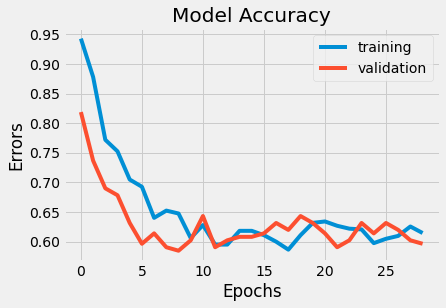

In [54]:
def plot_vgg():
  errors = [1 - x for x in history_vgg.history['accuracy']]
  val_errors = [1 - x for x in history_vgg.history['val_accuracy']]
  plt.style.use('fivethirtyeight')
  plt.title('Model Accuracy')
  plt.plot(errors, label="training")
  plt.plot(val_errors, label="validation")
  plt.xlabel('Epochs')
  plt.ylabel('Errors')
  plt.legend()
  plt.show()

plot_vgg()

In [55]:
def report_vgg():
    # Make a couple of preparations
    yLabels = []
    for images, labels in ds_test.unbatch():
        yLabels.append(labels.numpy().argmax())

    predProbs = model_vgg.predict(ds_test)    
    predClasses = predProbs.argmax(axis = 1)

    # Check the classification reports by printing it out
    print(classification_report(y_true = yLabels, y_pred = predClasses))

report_vgg()

3/3 [==============================] - 1s 341ms/step
              precision    recall  f1-score   support

           0       0.12      0.12      0.12         8
           1       0.00      0.00      0.00         9
           2       0.11      0.20      0.14        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         9
           5       0.14      0.11      0.12         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.11      0.11      0.11         9
           9       0.17      0.11      0.13         9
          10       0.00      0.00      0.00         9
          11       0.08      0.11      0.10         9
          12       0.00      0.00      0.00         9
          13       0.10      0.22      0.13         9
          14       0.17      0.33      0.22         9
          15       0.00      0.00      0.00        10
          16       0.00     